**1. Importation des packages**

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, classification_report, precision_score, recall_score,
                            confusion_matrix, roc_auc_score, roc_curve, auc)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import warnings
warnings.filterwarnings('ignore')

**2. Analyse de Risque Cardiaque - Comparaison de Modèles**

In [2]:
# Chargement des données
data = pd.read_csv("../data/clean_data.csv")
print(f"📊 Dimensions des données: {data.shape}")
data.head()

📊 Dimensions des données: (918, 12)


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


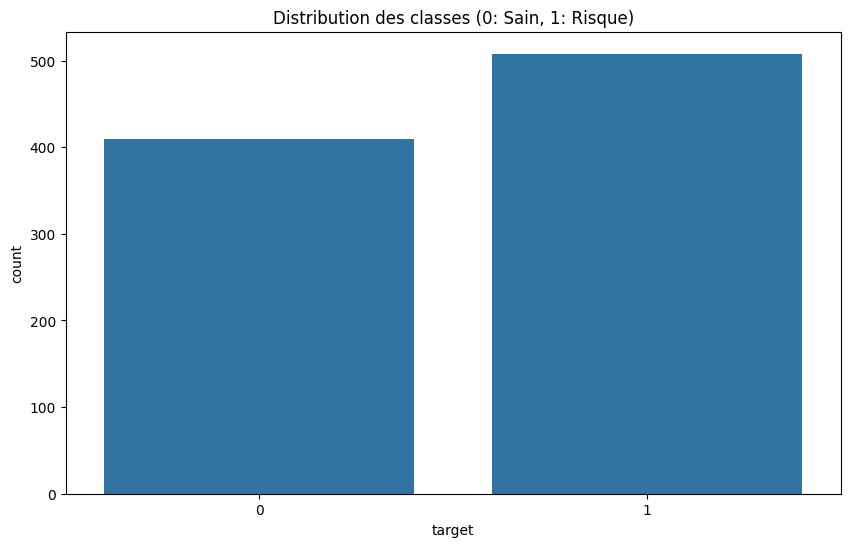

In [3]:
# Analyse exploratoire
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=data)
plt.title("Distribution des classes (0: Sain, 1: Risque)")
plt.show()

In [4]:
# Séparation des features/target
X = data.drop('target', axis=1)
y = data['target']

In [5]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

**3. Modèle Decision Tree optimisé**

In [6]:
num_features = ['age', 'resting bp s', 'cholesterol', 'oldpeak']
cat_features = ['sex', 'chest pain type', 'fasting blood sugar', 
                'resting ecg', 'exercise angina', 'ST slope']

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [7]:
# Optimisation avec GridSearchCV
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [8]:
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'resting '
                                                                          'bp '
                                                                          's',
                                                                          'cholesterol',
                                                                          'oldpeak']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['sex',
                                                                          'chest '
                                                                          'pain '
                                                                          'type',
                                                                          'fasting '
                                                                          'blood '
                                                                          'sugar',
                                                                          'resting '
                                                                          'ecg',
                                                                          'exercise '
                                                                          'angina',
                                                                          'ST '
                                                                          'slope'])])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [3, 5, 7, 10, None],
                         'classifier__min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [9]:
# Meilleurs paramètres
print(f"🔍 Meilleurs paramètres: {grid_search.best_params_}")
print(f"🏆 Meilleure accuracy (CV): {grid_search.best_score_:.3f}")

🔍 Meilleurs paramètres: {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__min_samples_split': 2}
🏆 Meilleure accuracy (CV): 0.843


In [10]:
# Évaluation finale
best_dt = grid_search.best_estimator_
y_pred = best_dt.predict(X_test)
y_proba = best_dt.predict_proba(X_test)[:, 1]

In [11]:
print("\n📝 Rapport de classification:")
print(classification_report(y_test, y_pred))


📝 Rapport de classification:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83        82
           1       0.84      0.90      0.87       102

    accuracy                           0.85       184
   macro avg       0.86      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



In [12]:
print(f"\n📊 AUC: {roc_auc_score(y_test, y_proba):.3f}")


📊 AUC: 0.899


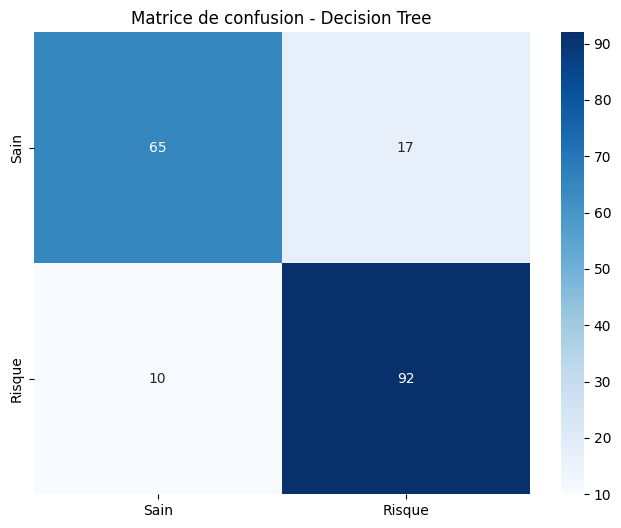

In [13]:
# Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sain', 'Risque'], yticklabels=['Sain', 'Risque'])
plt.title("Matrice de confusion - Decision Tree")
plt.show()

**4. Réseau de Neurones (ANN)**

In [14]:
# Préprocessing spécifique pour ANN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# Architecture du modèle
def build_ann(input_dim, dropout_rate=0.3):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    return model

In [16]:
ann_model = build_ann(X_train_scaled.shape[1])
ann_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Entraînement avec Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = ann_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5621 - auc: 0.6230 - loss: 0.6793 - val_accuracy: 0.7415 - val_auc: 0.8056 - val_loss: 0.5808
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7407 - auc: 0.8072 - loss: 0.5663 - val_accuracy: 0.7891 - val_auc: 0.8326 - val_loss: 0.5092
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7903 - auc: 0.8702 - loss: 0.4687 - val_accuracy: 0.8027 - val_auc: 0.8354 - val_loss: 0.4805
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8407 - auc: 0.9161 - loss: 0.3926 - val_accuracy: 0.8095 - val_auc: 0.8376 - val_loss: 0.4781
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8584 - auc: 0.9098 - loss: 0.3857 - val_accuracy: 0.8027 - val_auc: 0.8405 - val_loss: 0.4832
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8369 - auc: 0.9046 - loss: 0.3924 - val_accuracy: 0.8027 - val_auc: 0.8408 - val_loss: 0.4877
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms

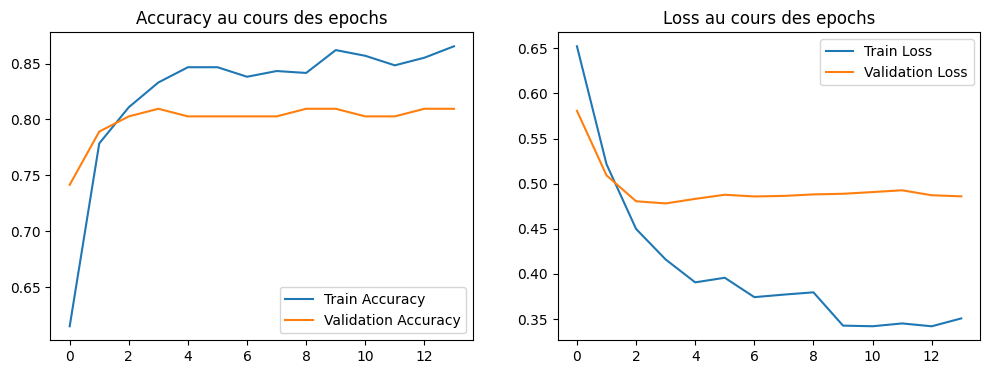

In [18]:
# Visualisation de l'apprentissage
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy au cours des epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss au cours des epochs')
plt.legend()
plt.show()

In [19]:
# Évaluation du modèle ANN
y_pred_ann = (ann_model.predict(X_test_scaled) > 0.5).astype(int)
y_proba_ann = ann_model.predict(X_test_scaled)

print("📝 Rapport de classification (ANN):")
print(classification_report(y_test, y_pred_ann))

print(f"\n📊 AUC (ANN): {roc_auc_score(y_test, y_proba_ann):.3f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
📝 Rapport de classification (ANN):
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        82
           1       0.86      0.91      0.89       102

    accuracy                           0.87       184
   macro avg       0.87      0.86      0.87       184
weighted avg       0.87      0.87      0.87       184


📊 AUC (ANN): 0.907


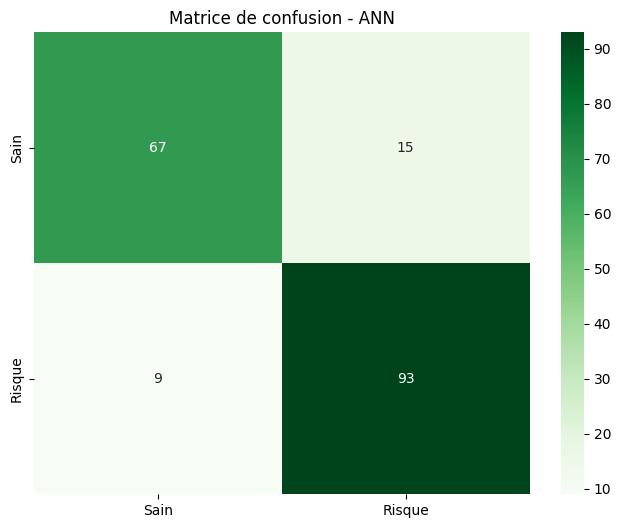

In [20]:
# Matrice de confusion ANN
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_ann), annot=True, fmt='d', cmap='Greens',
            xticklabels=['Sain', 'Risque'], yticklabels=['Sain', 'Risque'])
plt.title("Matrice de confusion - ANN")
plt.show()

**5. Analyse des Courbes d'Apprentissage**

In [21]:
# Fonction pour tracer les courbes d'apprentissage
def plot_learning_curve(estimator, title, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Exemples d'entraînement")
    plt.ylabel("Score (Accuracy)")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score entraînement")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score validation")
    
    plt.legend(loc="best")
    return plt


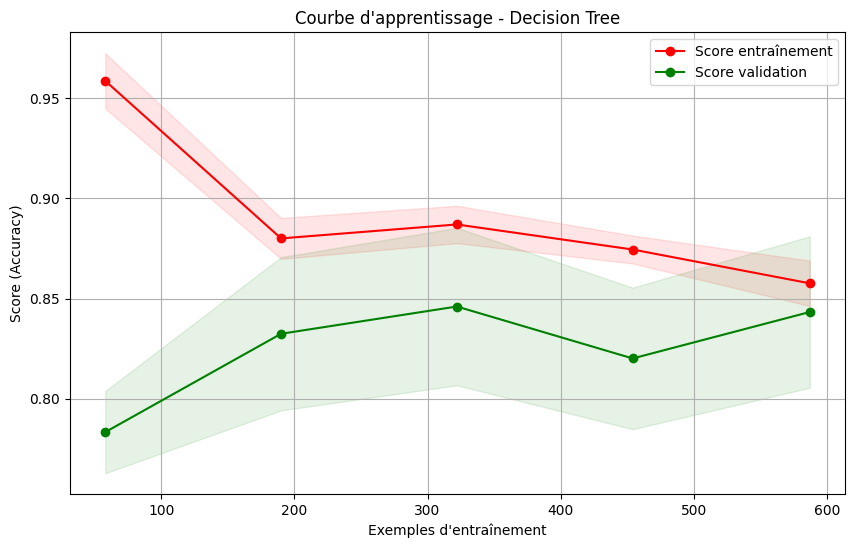

In [22]:
# Courbe d'apprentissage pour le Decision Tree
plot_learning_curve(best_dt, "Courbe d'apprentissage - Decision Tree", X_train, y_train)
plt.show()

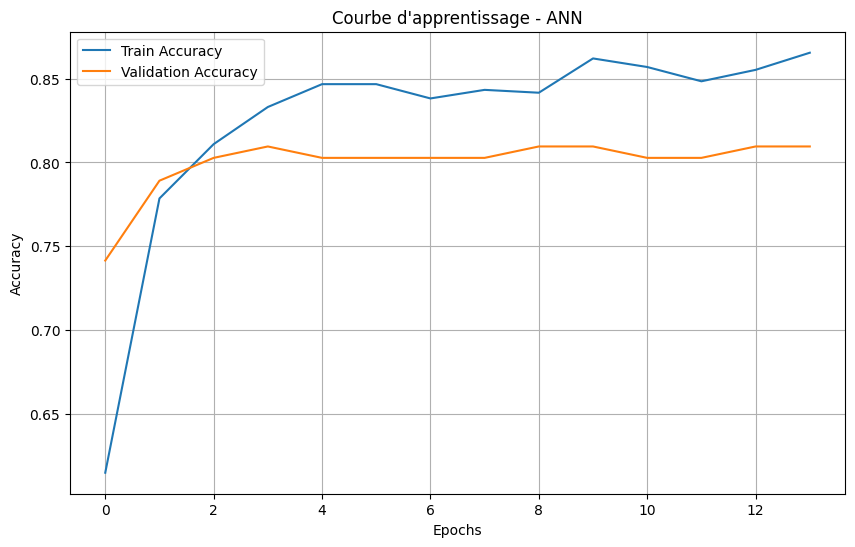

In [23]:
# Courbe d'apprentissage pour l'ANN (approximation)
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Courbe d'apprentissage - ANN")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

**6. Validation Curves pour Analyse d'Overfitting**

In [24]:
param_range_dt = [3, 5, 7, 10, 15, 20, 30]  # Removed None to avoid TypeError
train_scores, val_scores = validation_curve(
    best_dt, X_train, y_train,
    param_name="classifier__max_depth",
    param_range=param_range_dt,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

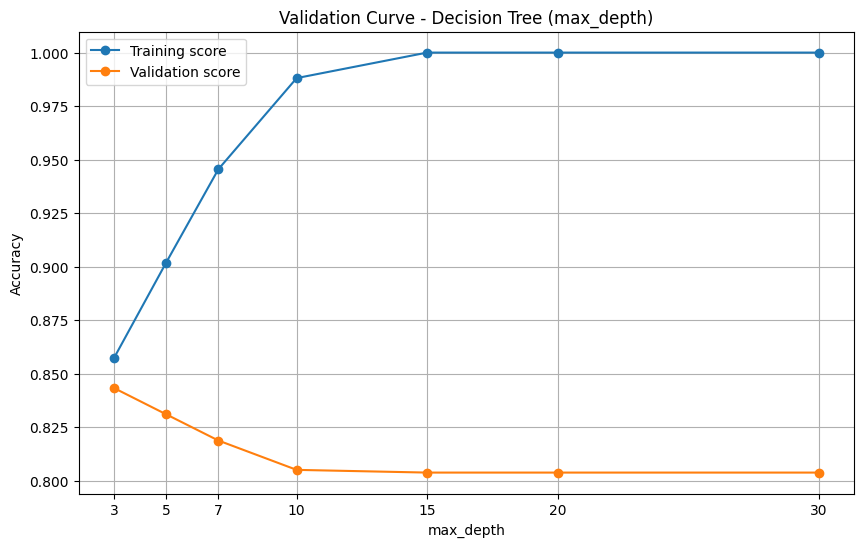

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(param_range_dt, np.mean(train_scores, axis=1), 'o-', label="Training score")
plt.plot(param_range_dt, np.mean(val_scores, axis=1), 'o-', label="Validation score")
plt.xticks(param_range_dt)
plt.title("Validation Curve - Decision Tree (max_depth)")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

In [26]:
# Validation Curve pour l'ANN (Dropout Rate)
param_range_ann = [0, 0.1, 0.2, 0.3, 0.5]
ann_train_scores = []
ann_val_scores = []

for dropout_rate in param_range_ann:
    print(f"Entraînement avec dropout = {dropout_rate}")
    model = build_ann(X_train_scaled.shape[1], dropout_rate=dropout_rate)
    
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        verbose=0
    )
    
    ann_train_scores.append(history.history['accuracy'][-1])
    ann_val_scores.append(history.history['val_accuracy'][-1])

Entraînement avec dropout = 0
Entraînement avec dropout = 0.1
Entraînement avec dropout = 0.2
Entraînement avec dropout = 0.3
Entraînement avec dropout = 0.5


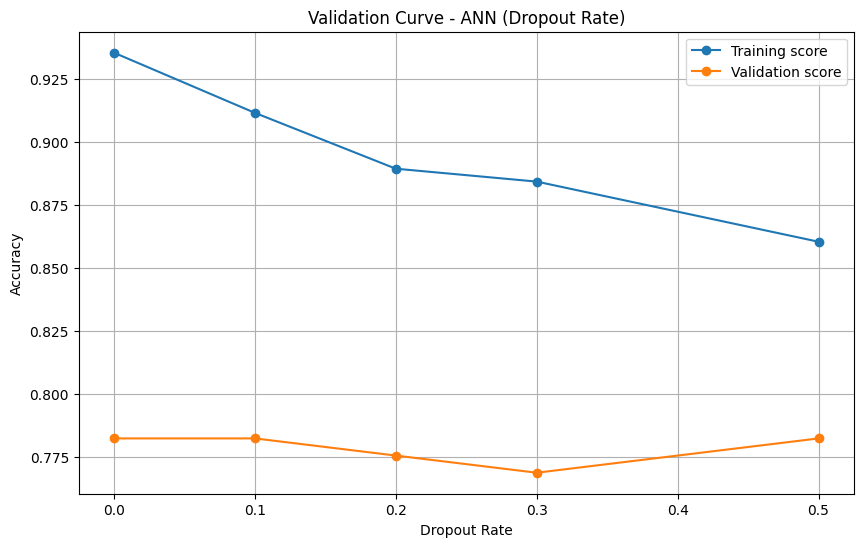

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(param_range_ann, ann_train_scores, 'o-', label="Training score")
plt.plot(param_range_ann, ann_val_scores, 'o-', label="Validation score")
plt.title("Validation Curve - ANN (Dropout Rate)")
plt.xlabel("Dropout Rate")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

**7. Comparaison Complète des Modèles**

In [28]:
# Courbes ROC comparées
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

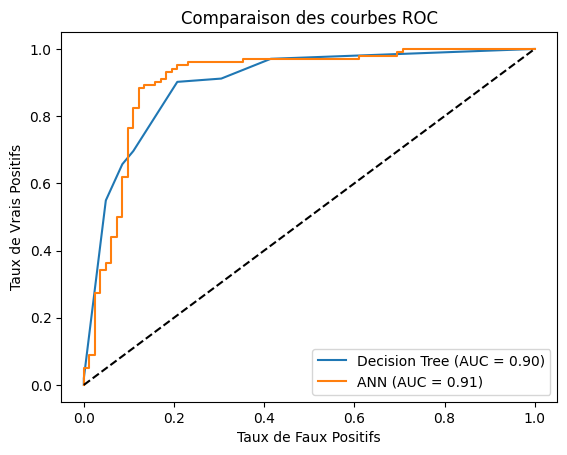

In [29]:
# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba)
roc_auc_dt = auc(fpr_dt, tpr_dt)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')

# ANN
fpr_ann, tpr_ann, _ = roc_curve(y_test, y_proba_ann)
roc_auc_ann = auc(fpr_ann, tpr_ann)
plt.plot(fpr_ann, tpr_ann, label=f'ANN (AUC = {roc_auc_ann:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Comparaison des courbes ROC')
plt.legend(loc='lower right')
plt.show()

In [30]:
# Tableau comparatif complet
comparison = pd.DataFrame({
    'Modèle': ['Decision Tree', 'Réseau de Neurones'],
    'Accuracy': [
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, y_pred_ann)
    ],
    'AUC': [roc_auc_dt, roc_auc_ann],
    'Précision (Classe 1)': [
        precision_score(y_test, y_pred, pos_label=1),
        precision_score(y_test, y_pred_ann, pos_label=1)
    ],
    'Rappel (Classe 1)': [
        recall_score(y_test, y_pred, pos_label=1),
        recall_score(y_test, y_pred_ann, pos_label=1)
    ],
    'Écart train/val': [
        np.mean(train_scores[-1] - val_scores[-1]),  # Pour max_depth optimal
        np.mean(np.array(ann_train_scores) - np.array(ann_val_scores))
    ]
})

In [31]:
display(comparison.style.background_gradient(cmap='YlGnBu', subset=['Accuracy', 'AUC'])\
                      .background_gradient(cmap='Reds', subset=['Écart train/val']))

,Modèle,Accuracy,AUC,Précision (Classe 1),Rappel (Classe 1),Écart train/val
0,Decision Tree,0.853261,0.898912,0.844037,0.901961,0.196235
1,Réseau de Neurones,0.869565,0.906863,0.861111,0.911765,0.117850


**8. Sauvegarde des Modèles**

In [33]:
import os

# Sauvegarde du Decision Tree
os.makedirs('./models', exist_ok=True)
joblib.dump(best_dt, './models/heart_model_pipeline_decision_tree.joblib')

['./models/heart_model_pipeline_decision_tree.joblib']

In [34]:
# Sauvegarde de l'ANN
ann_model.save('heart_ann_model.h5')
joblib.dump(scaler, 'ann_scaler.joblib')

['ann_scaler.joblib']

In [35]:
print("💾 Modèles sauvegardés avec succès!")

💾 Modèles sauvegardés avec succès!


**9. Interprétabilité**

In [36]:
# Feature Importance pour Decision Tree
dt_feature_importances = best_dt.named_steps['classifier'].feature_importances_

In [37]:
# Récupération des noms de features après preprocessing
cat_encoder = best_dt.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_features_names = cat_encoder.get_feature_names_out(cat_features)
all_features = num_features + list(cat_features_names)

In [38]:
# Création du DataFrame
fi_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': dt_feature_importances
}).sort_values('Importance', ascending=False)

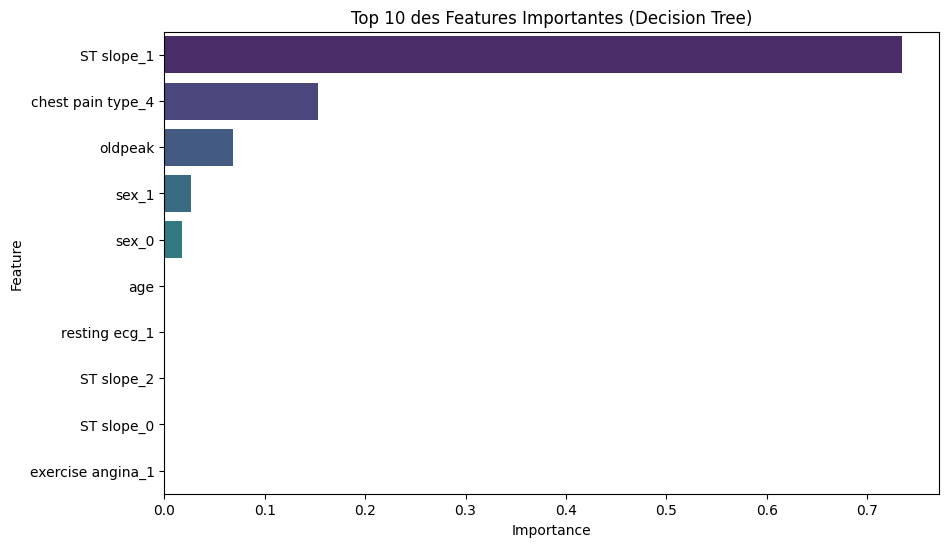

In [39]:
# Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df.head(10), palette='viridis')
plt.title('Top 10 des Features Importantes (Decision Tree)')
plt.show()

Nous obtenons donc que: 
                                    
**Decision Tree**: Plus rapide et interprétable, performance correcte Sensiblement égale à 85% AUC mais sensible à l'overfitting  

**ANN**: Meilleure performance Sensiblement égale à 8% AUC et plus robuste grâce au dropout

Nous pouvons donc prendre pour l'interprétabilité Decision Tree  et ANN pour la performance